In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

from MARBLE import utils, geometry, net, plotting

In [2]:
def initial_conditions(n, reps):
    eps=0.05
    X0_range = [geometry.sample_2d(n, [[-1,-1],[1,1]], 'random', seed=i) for i in range(reps)]
        
    return X0_range

def simulate_system(beta1, beta2, X0):
    p, v = simulate_phase_portrait('bogdanov_takens', t, X0, par = {'beta1': beta1, 'beta2': beta2})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = np.where((abs(p_) < 1).all(1))[0]
        pos.append(p_[ind,:])
        vel.append(v_[ind,:])
        
    return pos, vel

def sweep_parameters(beta1, beta2):
    
    if len(beta1)>1 and isinstance(beta2, int):
        par = [(b1,beta2) for b1 in beta1]
    elif len(beta2)>1 and isinstance(beta1, int):
        par = [(beta1,b2) for b2 in beta2]

    pos, vel = [], []
    X0_range = initial_conditions(n, len(beta1))
    for i, (b1,b2) in enumerate(par):
        p, v = simulate_system(b1, b2, X0_range[i])

        pos.append(np.vstack(p))
        vel.append(np.vstack(v))
        
    return pos, vel

def plot_phase_portrait(pos, vel, ax):
    if not isinstance(pos, list):
        pos = [pos]
    if not isinstance(vel, list):
        vel = [vel]

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style='>', lw=1, arrowhead=.03, axis=False, alpha=None)
    ax.axis('square')
    
def reject_outliers(data, m=1):
    data = data.mean(1)
    return np.where(abs(data - np.median(data)) < m * np.std(data))[0]

# For initial conditions, sample a rectangle uniformly

In [3]:
t0, t1, dt = 0, 1, 0.2
t = np.arange(t0, t1, dt)
n = 200
reps = 4

# Case 1

In [33]:
beta2 = 0
beta1 = np.linspace(-0.2,0.2,10)

# Generate phase portraits from random initial conditions while varying $\beta_1$

In [34]:
pos, vel = sweep_parameters(beta1, beta2)

# Subsample phase portrait

In [35]:
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.05)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

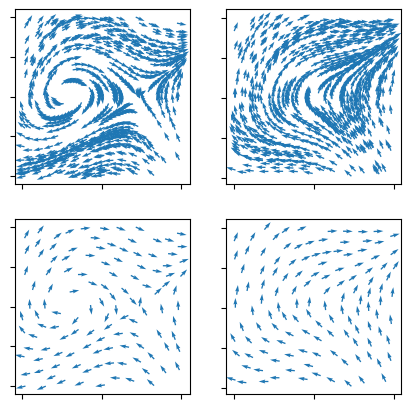

In [36]:
fig, ax = plt.subplots(2,2, figsize=(5,5))
    
plot_phase_portrait(pos[0], vel[0], ax[0,0])
plot_phase_portrait(pos[-1], vel[-1], ax[0,1])
plot_phase_portrait([pos_subsample[0]], [vel_subsample[0]], ax[1,0])
plot_phase_portrait([pos_subsample[-1]], [vel_subsample[-1]], ax[1,1])

# Train network

In [37]:
k=7
data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [46]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size
       'epochs': 20, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'diffusion': True,
       'inner_product_features': True,
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 256
epochs : 20
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
diffusion : True
inner_product_features : True
lr : 0.01
pretrained : False
vector : False
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 14
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  208
---- Treating features as scalar channels.

---- Training network ... 



KeyError: 'evals'

# Create embeddings and cluster

In [43]:
n_clusters = 30
data = model.evaluate(data)

# Visualise embedding

Performed umap embedding on embedded results.


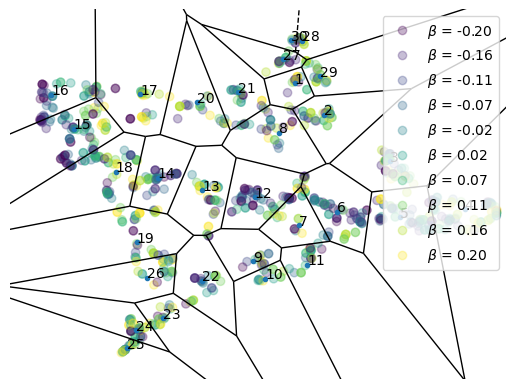

In [44]:
tsne_emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters, embed_typ='umap')
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(tsne_emb, data.y.numpy(), clusters, titles=titles)

Performed MDS embedding on embedded results.


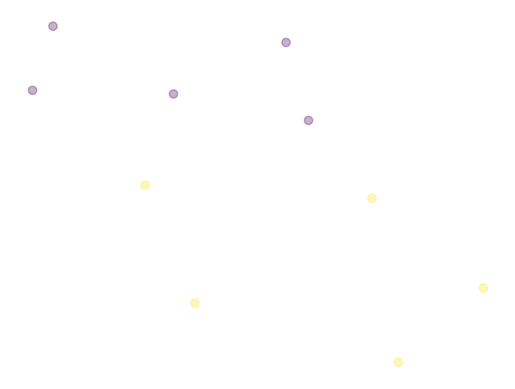

In [45]:
emb_MDS = geometry.embed(dist, embed_typ = 'MDS')
labels = [0 if b<0 else 1 for b in beta1]
plotting.embedding(emb_MDS, np.array(labels))

# Distance matrix

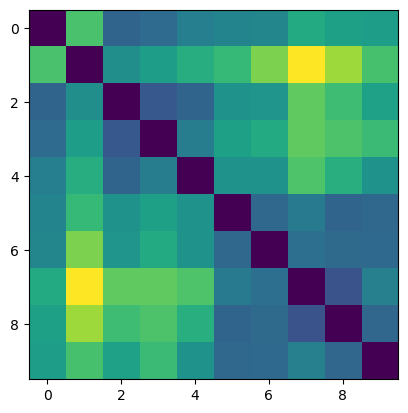

In [14]:
plt.imshow(dist)

# Case 2

In [23]:
beta2 = -1
beta1 = np.linspace(-.5,.5,40)

In [24]:
pos, vel = sweep_parameters(beta1, beta2)
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.025)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

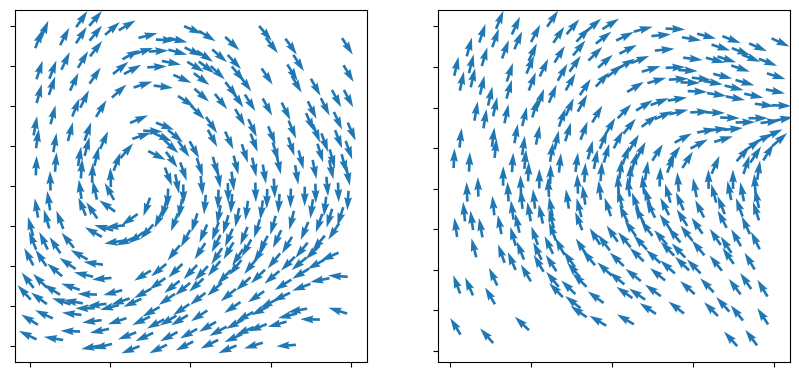

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

plot_phase_portrait([pos_subsample[0]], [vel_subsample[0]], ax[0])
plot_phase_portrait([pos_subsample[-1]], [vel_subsample[-1]], ax[1])

---- Settings: 

batch_size : 256
epochs : 20
order : 2
n_lin_layers : 2
hidden_channels : 16
out_channels : 3
diffusion : False
inner_product_features : True
lr : 0.01
pretrained : False
vector : False
frac_geodesic_nb : 2.0
frac_sampled_nb : -1
var_explained : 0.9
dropout : 0.0
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 2
dim_emb : 2
n_geodesic_nb : 14
n_sampled_nb : -1

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  208
---- Treating features as scalar channels.

---- Training network ... 

Epoch: 1, Training loss: 54.2336, Validation loss: 61.0259
Epoch: 2, Training loss: 48.9233, Validation loss: 57.5733
Epoch: 3, Training loss: 46.3693, Validation loss: 50.2623
Epoch: 4, Training loss: 44.6562, Validation loss: 52.8527
Epoch: 5, Training loss: 45.0680, Validation loss: 52.3965
Epoch: 6, Training loss: 45.0787, Validation loss: 52.6817
Epoch: 7, Training loss: 44.2379, Validation loss: 51.0336
Epoch: 8, Trai

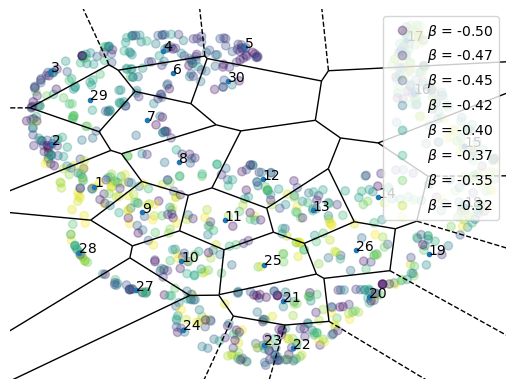

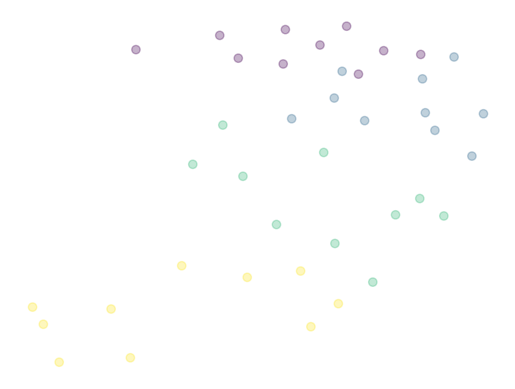

In [27]:
k=7
data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size
       'epochs': 20, #optimisation epochs
       'order': 2, #order of derivatives
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 3,
       'diffusion': False,
       'inner_product_features': True,
      }

model = net(data, **par)
model.run_training(data)

n_clusters = 30
data = model.evaluate(data)
tsne_emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters, embed_typ='umap')
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(tsne_emb, data.y.numpy(), clusters, titles=titles)
emb_MDS = geometry.embed(dist, embed_typ = 'MDS')
#labels = [0 if b1<-beta2**2/4 else 1 for b1 in beta1]
labels = []
for b in beta1:
    if b<-beta2**2/4:
        labels.append(0)
    elif b>-beta2**2/4 and b<0:
        labels.append(1)
    elif b<beta2**2/4 and b>0:
        labels.append(2)
    elif b>beta2**2/4:
        labels.append(3)
plotting.embedding(emb_MDS, np.array(labels))